# Lab 3: Clasificacion y deteccion

Debe formar grupo de hasta 3 personas para los laboratorios.

__Estudiante 1:__ Leonardo Achá Boiano \
__Estudiante 2:__ Bruno Ramiro Rejas Montero \
__Estudiante 3:__ Matias Adorno Mazzocato \
__Estudiante 4:__ Adrian Carhuaz \

__Fecha de inicio:__ 10 de Abril del 2023 \
__Fecha de entrega:__ 20 de Abril del 2023 (18:00 horas)

---
## Pipeline

Recuerde que para cualquier proyecto de Vision computacional es necesario realizar la pipeline mostrada a continuacion (Tambine revisada durante las lecciones):

<img src="images\pipeline.png" width="80%" height="80%">

Durante este laboratorio realizaran cada una de las etapas de esta pipeline!! 

1. Input Data - extraer la informacion, imagenes
2. Segmentacion - preprocesamineto de la imagen, estandarizar, reducir ruido, etc 
3. Descripcion - encontrar un vector de caracteristicas 
4. Clasificacion - mediante el uso de los vectores de caracteristicas clasificar la imagen en su clase, label, correspondiente. Note que en este laboratorio no se estara usando ningun algoritmo de Machine Learning o Deep Learning. Este clasificador, o tambien conocido como `modelo`, sera un clasificador basado unicamente en el vector de caracteristicas!
---

## Exercise 1: Object detection (HOG + SVM) - 12 pts

Ya se ha entrenado un clasificador usando HOG + SVM. Ahora, se usara la misma idea pero para entrenar un clasificador (HOG + SVM) para la deteccion de objetos.

## Object Detection

La siguiente imagen es una salida típica de un sistema de detección de peatones.

<center><img src="https://www.learnopencv.com/wp-content/uploads/2019/09/cv1-week8-object-detection.jpg" width=500/></center>

<center>Figura 1: Resultado típico de la detección de peatones/personas.</center> 

A diferencia de un clasificador que actúa sobre toda la imagen, en la detección de objetos necesitamos encontrar la ubicación del objeto en la imagen. Aquí hay algunas cosas a tener en cuenta al pensar en la detección de objetos.

1. **Ubicación:** El objeto que intentamos detectar puede aparecer en cualquier ubicación de una imagen.

2. **Escala:** La escala o el tamaño del objeto pueden ser arbitrarios. En el paper de Dalal y Triggs, el detector de peatones fue entrenado para un parche de imagen de tamaño 64 x 128. Sin embargo, un peatón puede aparecer en una imagen de cualquier tamaño. En la imagen de arriba, los dos corredores detectados tienen una escala muy diferente. También debemos elegir el tamaño más pequeño del objeto que nos interesa. En la imagen de arriba, probablemente no nos interesen los pequeños corredores en el fondo.

3. **Rotación:** Es posible que el objeto no esté en posición vertical. Puede ser necesario rotarlo.

4. **Non-Maximum Supression:** Finalmente, la detección de objetos a menudo requiere un paso de procesamiento posterior llamado Non-Maximum Supression. Si se detecta un objeto en una ubicación de píxel en particular, existe la posibilidad de que se vuelva a detectar en una ubicación de píxel cercana. Ambos cuadros delimitadores apuntan al mismo objeto y, por lo tanto, simplemente necesitamos rechazar los cuadros delimitadores superpuestos. Esto se denomina Non-Maximum Supression.


### (Question) Diferencias entre Clasificacion y Deteccion - CON SUS PROPIAS PALABRAS - NO COPIAR Y PEGAR EL TEXTO DE ARRIBA

__answer:__

### (Question) Explique cada paso en la deteccion de objetos. Busqueda de ubicacion, Non-Maximum Supression, Clasificar un Patch, Escala. ESTA EXPLICACION DEBE SER DETALLADA - NO COPIAR Y PEGAR EL TEXTO DE ARRIBA

__answer:__

In [116]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [117]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10.0,10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## Helpers 

In [118]:
# returns image paths in given folder
# with extensions as defined in imgExts
def getImagePaths(folder, imgExts):
    imagePaths = []
    for x in os.listdir(folder):
        xPath = os.path.join(folder, x)
        if os.path.splitext(xPath)[1] in imgExts:
            imagePaths.append(xPath)
    return imagePaths


# read images in a folder
# return list of images and labels
def getDataset(folder, classLabel):
    """
    Given a folder path and class label, this function reads all the image files in the folder with extensions '.jpg',
    '.png', and '.jpeg' and returns the list of images and their corresponding class labels.

    Args:
        folder (str): Path to the folder containing the images.
        classLabel (int): The class label to be assigned to all the images in the folder.

    Returns:
        tuple: A tuple of two lists - a list of images and a list of labels.

    Example Usage:
        folder_path = '/path/to/folder/containing/images'
        class_label = 0  # Assuming all images in the folder belong to class 0

        # Get the dataset
        images, labels = getDataset(folder_path, class_label)

        # Print the number of images and their corresponding labels
        print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    """
    images = []
    labels = []
    imagePaths = getImagePaths(folder, ['.jpg', '.png', '.jpeg'])
    for imagePath in imagePaths:
        im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
        images.append(im)
        labels.append(classLabel)
    return images, labels


# create a directory if it doesn't exist
def createDir(folder):
    try:
        os.makedirs(folder)
    except OSError:
        print('{}: already exists'.format(folder))
    except Exception as e:
        print(e)

## Como entrenar un Detector de personas
En esta sección aprenderemos a entrenar un detector de objetos basado en HOG + SVM. Entrenaremos un detector de personas utilizando el conjunto de datos de peatones de INRIA. La carpeta contiene dos subcarpetas:

1. __train_64x128_H96:__ contiene las imágenes recortadas de peatones y redimensionadas a 64x128 (ejemplos positivos)

2. __test_64x128_H96:__ contiene imágenes recortadas que no contienen peatones. (ejemplos negativos)

Los datos de entrenamiento también se pueden descargar desde **[este enlace](https://www.filepicker.io/api/file/VQKdmzKqSLWruVhx7Xdd)**. Descomprima el archivo `INRIAPerson.zip` y guárdelo en la carpeta `./images/`. Asegurese que toda la data este en esta carpeta caso contrario puede tener errores mas adelante.

## 1. Setup SVM Classifier

Realice las sigueintes funciones:

1. Inicializar SVM - `svmInit`
2. Entrenar SVM - `svmTrain`
3. Predecir SVM - `svmPredict`
4. Evaluar SVM - `svmEvalute` - Esta funcion debe devolver, numero de correctas y el error en porcentaje. 

In [119]:
# Initialize SVM with parameters
def svmInit(C, gamma):
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_RBF)
    model.setType(cv2.ml.SVM_C_SVC)
    return model

# Train SVM on data and labels
def svmTrain(model, samples, labels):
    labels = labels.astype(int)
    model.train(samples, cv2.ml.ROW_SAMPLE, labels)
    return model

# predict labels for given samples
def svmPredict(model, samples):
    samples = np.float32(samples)
    _, result = model.predict(samples)
    return result.ravel()

# evaluate a model by comparing
# predicted labels and ground truth
def svmEvaluate(model, samples, labels):
    """
    Evaluate an SVM model on a given set of samples and labels.
    
    Parameters:
    -----------
    model : sklearn.svm.SVC
        The SVM model to be evaluated.
    samples : array-like
        The samples to be used for evaluation.
    labels : array-like
        The true labels of the samples.
    
    Returns:
    --------
    count_nonzero : int
        The number of correct predictions.
    error : float
        The error rate of the predictions in percentage.
    """
    predictions = svmPredict(model, samples)
    right = (labels == predictions)
    error = (1-right.mean()) * 100
    return np.count_nonzero(right), error



## 2. Setup HoG Feature Detector

Realice las funciones para:
1. `computeHOG` - Calcular los descriptores HOG para un conjunto de imágenes 
2. `prepareData` - Convertir el descriptor HOG al formato de datos utilizado por SVM.

Finalmente, inicialice los parametros HOG usando la funcion `cv2.HOGDescriptor`

In [120]:
# compute HOG features for given images
def computeHOG(hog, images, des_len=3780):
    """
    Compute Histogram of Oriented Gradients (HOG) features for the given images.
    This function takes in an instance of the cv2.HOGDescriptor class, `hog`, 
    and a list of images, `images`, as input. It computes the HOG feature vector 
    for each image using `hog.compute(image)`, flattens the resulting feature vector 
    using the `flatten()` method, and reshapes it to 
    the desired length `des_len` using the `if-else` statements.

    If the length of the flattened feature vector is greater than or equal to `des_len`, 
    it truncates it to the desired length using the `[:des_len]` slice. 
    If the length of the flattened feature vector is less than `des_len`, 
    it appends zeros to it until it reaches the desired length 
    using `np.concatenate((hog.compute(image).flatten(), 
    np.zeros(des_len - hog.compute(image).flatten().shape[0])))`.

    The resulting `hogData` list will contain the reshaped 
    HOG feature vectors for each image in the `images` list.

    Parameters:
    -----------
    hog : cv2.HOGDescriptor
        Instance of the cv2.HOGDescriptor class used to compute HOG features.
    images : list
        List of images for which HOG features need to be computed.
    des_len : int, optional
        Desired length of the HOG feature vector after reshaping. Default value is 3780.

    Returns:
    --------
    hogData : list
        List of reshaped HOG feature vectors for each image in the `images` list.
    """
    hogData = [hog.compute(image).flatten()[:des_len] if hog.compute(image).flatten().shape[0] >= des_len else np.concatenate((hog.compute(image).flatten(), np.zeros(des_len - hog.compute(image).flatten().shape[0]))) for image in images]
    return hogData


# Convert HOG descriptors to format recognized by SVM
def prepareData(hogFeatures):
    featureVectorLength = len(hogFeatures[0])
    features = np.float32(hogFeatures).reshape(-1, featureVectorLength)
    return features

In [121]:
# Initialize HOG parameters
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, 
                      nbins,derivAperture, winSigma, 
                      histogramNormType,L2HysThreshold, 
                      gammaCorrection, nlevels, signedGradient)

## 3. Training and Testing

In [122]:
# Flags to turn on/off training or testing
trainModel = True
testModel = True
queryModel = True

Estamos utilizando el conjunto de datos de peatones de INRIA para entrenar nuestro modelo. INRIA viene con carpetas de `train` y `test`. 

Cada una de estas carpetas de train/test tiene carpetas `pos` y `neg` que contienen imágenes positivas y negativas. 

Dado que SVM se entrena con vectores del mismo tamaño, se ha creado parches del mismo tamaño desde directorios pos y neg hasta `posPatches` y `negPatches`. 

`negPatches` contiene 10 parches seleccionados al azar de cada imagen en el directorio neg. 

`posPatches` contiene 1 parche para cada imagen en el directorio pos después de quitar el relleno (16 para entrenar y 3 para probar).

In [123]:
# Path to INRIA Person dataset
rootDir = '/images/INRIAPerson'

# set Train and Test directory paths
trainDir = 'images/INRIAPerson/test_64x128_H96'
testDir = 'images/INRIAPerson/test_64x128_H96'

### 3.1 Training

1. Leer imágenes de los directorios `posPatches` y `negPatches` 
2. Crear vectores de labels correspondientes a ellos. +1 para pos y -1 para neg. 
3. Fusionar los vectores de imagen y labels manteniendo las muestras negativas después de las muestras positivas.
4. Calcular las caracteristicas HoG
5. Preparar las caracteristicas para el entrenamiento
6. Inicializar, entrenar y guardar el modelo SVM como `pedestrian.yml`

Para comprar su implementacion con lo entregado, asegurese de imprimir lo siguiente:

- El tamano de las imagenes positivas y negativas deben ser iguales `{(128, 64, 3)}`
- Mostrar el numero total de los ejemplos positivos y negativos: `positive - 2416, 2416 || negative - 12180, 12180`
- Mostrar las dimensiones de la data y los lables - `trainData: (14596, 3780), trainLabels:(14596,)`


In [124]:
# ================================ Train Model =====================
if trainModel:
    # Read images from Pos and Neg directories
    

    # Label 1 for positive images and -1 for negative images
    # Use helper functions getDataset
    label=[1, -1]
    posTrainImages, posTrainLabels=getDataset(r'images\INRIAPerson\train_64x128_H96\posPatches', label[0])
    negTrainImages, negTrainLabels=getDataset(r'images\INRIAPerson\train_64x128_H96\negPatches', label[1])

    # Check whether size of all positive and negative images is same
    print(f"{posTrainImages[0].shape}")
    print(f"{negTrainImages[0].shape}")

    # Print total number of positive and negative examples
    print(f'positive - {len(posTrainImages)}, {len(posTrainLabels)} || negative - {len(negTrainImages)}, {len(negTrainLabels)}')

    # Append Positive/Negative Images/Labels for Training
    # use np.concatenate and np.array. Check the axis parameter!
    #      np.concatenate((np.array(img), np.array(lable)), axis=?)
    trainImages = np.concatenate((np.array(posTrainImages), 
                        np.array(negTrainImages)), axis=0)
    trainLabels = np.concatenate((np.array(posTrainLabels), 
                          np.array(negTrainLabels)), axis=0)
    
    # Now compute HOG features for training images and 
    # convert HOG descriptors to data format recognized by SVM.
    # Compute HOG features for images
    trainHOG = computeHOG(hog, trainImages)

    # Convert hog features into data format recognized by SVM
    trainFeatures = prepareData(trainHOG)

    # Check dimensions of data and labels
    print(f'trainData: {trainFeatures.shape}, trainLabels:{trainLabels.shape}')
    
    # Finally create an SVM object, train the model and save it.
    # Initialize SVM object
    C = 5 
    # The C parameter is a scalar value that controls 
    # the trade-off between training error and model 
    # complexity. A smaller value of C will result in 
    # a wider margin, but may lead to a higher training 
    # error if the data is not linearly separable. 
    gamma = 0.02 
    # The gamma value is a scalar value that 
    # controls the degree of gamma correction. 
    # A gamma value of 1.0 means no correction 
    # is applied, while a value greater than 
    # 1.0 will increase the brightness and a value 
    # less than 1.0 will decrease the brightness of the image.
    
    # Training
    model = svmInit(C=C, gamma=gamma)  
    model = svmTrain(model, trainFeatures, trainLabels)
    # Save your model
    model.save('models/pedestrian.yml')

(128, 64, 3)
(128, 64, 3)
positive - 2416, 2416 || negative - 12180, 12180
trainData: (14596, 3780), trainLabels:(14596,)


In [125]:
# Get the support vectors and convert to size (1, n)
support_vectors = model.getSupportVectors()
mean_sv = np.mean(support_vectors, axis=0, keepdims=True)
mean_sv.shape

(1, 3780)

### 3.2 Testing
1. Cargar el modelo entrenado `pedestrian.yml`
2. Cargar las imagenes positivas y negativas de entrenamiento
3. Fusionar los vectores de imagen y labels manteniendo las muestras negativas después de las muestras positivas.
4. Calcular las HOG Features
5. Preparar la data para la evaluacion del modelo
6. Evaluar el modelo, obtener el numero de correctas predicciones y el error en las imagenes positivas y negativas
7. Calcular True y False positives
8. Calcular True y False negatives
9. Calcular Precision y Recall
10. Mostrar estos valores calculados


Para entender True positives, False positives, True negatives, False negatives. Recall, and Precision please read [here](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

In [126]:
# ================================ Test Model ===============
if testModel:
    # Load model from saved file
    savedModel = cv2.ml.SVM_load('models/pedestrian.yml')
    
    # Evaluate our test dataset for positive and 
    # negative images separately to calculate True/False Positives 
    # and True/False Negatives. Read dirs from posPatches and negPatches
    
    # follow the same flow to prepare data as we did for training images.
    # Label 1 for positive images and -1 for negative images
    label=[1, -1]
    posTestImages, posTestLabels=getDataset(r'images\INRIAPerson\test_64x128_H96\posPatches', label[0])
    negTestImages, negTestLabels=getDataset(r'images\INRIAPerson\test_64x128_H96\negPatches', label[1])

    # Check whether size of all positive and negative images is same
    #print(f"{posTestImages[0].shape}")
    #print(f"{negTestImages[0].shape}")

    # Print total number of positive and negative examples
    #print(f'positive - {len(posTestImages)}, {len(posTestLabels)} || negative - {len(negTestImages)}, {len(negTestLabels)}')

    # Compute HOG features for test pos images
    # Prepare the data
    posTestHOG = computeHOG(hog, posTestImages)
    negTestHOG = computeHOG(hog, negTestImages)

    # Convert hog features into data format recognized by SVM
    posTestLabels = np.array(posTestLabels)
    posTestFeatures = prepareData(posTestHOG)
    # Check dimensions of data and labels
    #print(f'testPositiveData: {posTestFeatures.shape}, testPositiveLabels:{posTestLabels.shape}')
    
    # Run classification on test data for positive images 
    # and calculate True Positives and False Positives.
    # use svmEvaluate this return two values!
    
    # Calculate True and False Positives
    # Evaluate the SVM model on the positive test set
    posCount, posError = svmEvaluate(model, posTestFeatures, posTestLabels)
    totalPositives=len(posTestImages)

    TP = posCount-(posCount*posError/100)
    FP = totalPositives - TP
    
    print(f'TP: {TP:.2f}, FP: {FP:.2f}, Total: {totalPositives}, Error on positive samples: {posError:.2f}%')
    
    # Similarly run classification on negative test data 
    # and calculate True and False Negatives
    # Test on negative images
    # Evaluate the SVM model on the negative test set'
    negTestLabels = np.array(negTestLabels)
    negTestFeatures = prepareData(negTestHOG)
    # Check dimensions of data and labels
    #print(f'testNegativeData: {negTestFeatures.shape}, testNegativeLabels:{negTestLabels.shape}')

    negCount, negError = svmEvaluate(model, negTestFeatures, negTestLabels)
    totalNegatives=len(negTestImages)

    TN = negCount-(negCount*negError/100)
    FN = totalNegatives - TN
    
    print(f'TN: {TN:.2f}, FN: {FN:.2f}, Total: {totalNegatives}, Error on negative samples: {negError:.2f}%')
          
    # Calculate Precision and Recall
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    # Print 
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}')

TP: 984.73, FP: 141.27, Total: 1126, Error on positive samples: 6.48%
TN: 4466.23, FN: 63.77, Total: 4530, Error on negative samples: 0.71%
Precision: 0.87, Recall: 0.94


### (Question) Que conclusion puede sacar de los valores obtenidos?

**Resultados Iniciales con SVM´s C=5 y gamma=1:**  
TP: 1126.00, FP: 0.00, Total: 1126, Error on positive samples: 0.00%  
TN: 16.94, FN: 4513.06, Total: 4530, Error on negative samples: 93.89%  
Precision: 1.00, Recall: 0.20  
Se puede concluir de los valores obtenidos que el dataset de entrenamiento se encuentra plagado de bias. Seguramente la gran mayoria de las imagenes de entrenamiento son positivas, lo que ocasiona que el modelo tenga problemas identificando las muestras negativas. Otra causa podria ser que las imagenes se encuentren incorrectamente identificadas, con imagenes positivas mescladas entre las negativas(o viceversa) en el training set.     
Ya que el modelo tuvo un desempeño remarcable en muestras positivas(1126 verdaderos positivos y 0 falsos negativos), con un error del 0%. Sin embargo, el modelo tuvo un desempeño terribe en las muestras negativas con un tasa de error del 93.89%.  
La precision del modelo es 1.00, indicando que todas las predicciones positivas hachas por el modelo son correctas.  
El recall del modelo es 0.20, indicando que solo el 20% del total de muestras positivas fueron correctamente identificadas por el modelo.  
  
**Resultados tras some tunning de SVM's gamma=0.02:**  
TP: 988.48, FP: 137.52, Total: 1126, Error on positive samples: 6.31%  
TN: 4472.19, FN: 57.81, Total: 4530, Error on negative samples: 0.64%  
Precision: 0.88, Recall: 0.94    
  
La modificacion del gamma de entrenamiento de SVM permitió reducir significativamente el error en analisis de muestras negativas a costa de aumentar ligeramente el error en muestras positivas.  
En general, el modelo parece haber funcionado bien con una alta recuperación y precisión.

## Testing the model on a new image 
Se quiere cargar los modelos SVM entrenados por usted y usarlos para encontrar peatones en una nueva imagen. Para esto, necesitamos usar la función `detectMultiScale` presente en OpenCV. 

### Usage of hog.**detectMultiScale**

Una vez que el clasificador se carga en el detector, la función **detectMultiScale**  se debe utilizar para detectar objetos en una imagen.


### Function Syntax

```python
(foundLocations, foundWeights) = hog.detectMultiScale(img, hitThreshold=hitThreshold, winStride=winStride, padding=padding, scale=scale,  groupThreshold=groupThreshold, useMeanshiftGrouping=useMeanshiftGrouping)
```

where

- **`img`** = Input image.

- **`foundLocations`** = A vector of rectangles corresponding to detected objects.

- **`foundWeights`** = SVM response (weights) associated with the above bounding boxes. You can treat this weight as a measure of confidence.

- **`hitThreshold`** = The SVM response threshold above which we say the rectangle is an object. Usually, the default value of 0 is good. Note elements of foundWeights will always be greater than hitThreshold.

- **`winStride`** = The stride of the object detection window as explained in the Location search subsection above.

- **`padding`** = Padding added to the entire image so objects near the boundary can be detected. Usually this is set to half the detection window width. E.g. in pedestrian detection where the detection window has size 64 x 128, the padding is set to 32 x 32.

- **`scale`** = To create the image pyramid, the image at a level is scaled down by this number. E.g. when scale is set to 1.05, it means that second level of of the pyramid is created by resizing the original image by a factor of 1/1.05. The third level is created by rescaling the image at level 2 by a factor of 1/1.05 and so on.

- **`groupThreshold`** = In the non-maximum suppression step, this parameter is used to prune out clusters that have fewer than finalTreshold number of rectangles.

- **`useMeanshiftGrouping`** = Use the non-standard grouping algorithm based on meanshift. Based on reading the code and the documentation, it is not clear when this is a good idea.

### Query Model
1. Cargar su modelo
2. Extraer los parametros del modelo SVM `getSupportVecotrs()`
3. Ajustar el SVMdetector en HOG
4. Cargar imagenes de prueba
5. Utilizar `hog.detectMultiScale`
6. Dibujar los rectangulos por la imagen

In [127]:
model.getSupportVectors().shape

(1977, 3780)

In [128]:
# ================================ Query Model =============================================
# Run object detector on a query image to find pedestrians
# We will load the model again and test the model
# This is just to explain how to load an SVM model
# You can use the model directly
if queryModel:
    # load model
    model = cv2.ml.SVM_load('models/pedestrian.yml')
    
    # extract support vector and rho(bias) from model
    sv = model.getSupportVectors()[0:1, :]

    rho, aplha, svidx = model.getDecisionFunction(0)
    svmDetector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
    svmDetector[:-1] = -sv[:]
    svmDetector[-1] = rho

    print(f'Detector Shape: {svmDetector.shape} Expected Size at Descriptor: {hog.getDescriptorSize()}')

    # check if the size of svmDetector matches the expected size of the HOG descriptor
    #if svmDetector.shape[0] != hog.getDescriptorSize():
    #    raise ValueError("Size of SVM detector does not match expected size of HOG descriptor")
    
    # set our SVMDetector in HOG
    hog.setSVMDetector(svmDetector)

    # Test image
    filename = "images/pedestrians/3.jpg"
    queryImage = cv2.imread(filename, cv2.IMREAD_COLOR)

    # Run pedestrian detector at an fixed height image
    finalHeight = 800.0
    scale = finalHeight / queryImage.shape[0]
    queryImage = cv2.resize(queryImage, None, fx=scale, fy=scale)

    ## TODO
    # detectMultiScale will detect at nlevels of image by scaling up
    # and scaling down resized image by scale of 1.05
    # pameters explanation: https://pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
    (rects, weights) = hog.detectMultiScale(queryImage, 
                        winStride=(4,4),# step size in x and y dir for sliding window
                                        # start with (4, 4) and increase. Trede-off speed-accuracy
	                    padding=(8,8),  # amount of pixels the ROI is padded with prior to HOG feature vector extraction and SVM classification
                                        # Typical values for padding include (8, 8), (16, 16), (24, 24), and (32, 32).
                        scale=1.05,     # scale of the image pyramid
                                        # typical values for scale  are normally in the range [1.01, 1.5]
                                        # as large as possible without significantly sacrificing detection accuracy
                        useMeanshiftGrouping=0) #o apply mean-shift grouping to the detected bounding boxes
                                                #alternative to non-maxima suppression (NMS)
    
    queryImage=queryImage.copy()
    # draw detected bounding boxes over image
    for (x, y, w, h) in rects:
        cv2.rectangle(queryImage, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ## ENDTODO

    plt.imshow(queryImage[:,:,::-1])
    plt.show()

Detector Shape: (3781,) Expected Size at Descriptor: 81


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\hog.cpp:120: error: (-215:Assertion failed) checkDetectorSize() in function 'cv::HOGDescriptor::setSVMDetector'


## 4. Comparacion Nuestro modelo (Trained Model) vs OpenCV's Pedestrian Detector

Hasta ahora hemos probado nuestro modelo en parches de imagen de 64x128. Ahora ejecutaremos nuestro modelo en algunas imágenes de la vida real. También compararemos nuestros resultados con el detector de personas predeterminado de OpenCV. 

El detector de personas de OpenCV también está entrenado en el conjunto de datos INRIA. 

Completar:
1. Dibujar rectángulos verdes para los resultados de nuestro modelo
2. Dibujar rectángulos rojos para los resultados del detector de personas de OpenCV.


Cargue el modelo, extraiga los vectores de soporte y la función de decisión (rho) de este modelo. Ahora cree un detector SVM para HOG agregando rho al final de los vectores de soporte. Ahora configure este detector SVM en HOG.

In [ ]:
# Load model trained by us
model = cv2.ml.SVM_load('models/pedestrian.yml')
sv = model.getSupportVectors()
rho, aplha, svidx = model.getDecisionFunction(0)
svmDetectorTrained = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
svmDetectorTrained[:-1] = -sv[:]
svmDetectorTrained[-1] = rho

# set SVMDetector trained by us in HOG
hog.setSVMDetector(svmDetectorTrained)

ValueError: could not broadcast input array from shape (1989,4455) into shape (4455,)

Inicialice HOG y configure el detector de personas predeterminado de OpenCV como detector SVM en HOG.

In [ ]:
# OpenCV's HOG based Pedestrian Detector
# Here Use the same parameters as before 
hogDefault = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                               cellSize, nbins, derivAperture,
                               winSigma, histogramNormType, 
                               L2HysThreshold,gammaCorrection,
                               nlevels, signedGradient)

svmDetectorDefault = cv2.HOGDescriptor_getDefaultPeopleDetector()
hogDefault.setSVMDetector(svmDetectorDefault)

Leer imágenes para el directorio de peatones que tiene algunas imágenes del mundo real. Ejecutaremos la detección en imágenes con altura = 800

processing: images/pedestrians/race.jpg
Trained Detector :: pedestrians detected: 9
Default Detector :: pedestrians detected: 10


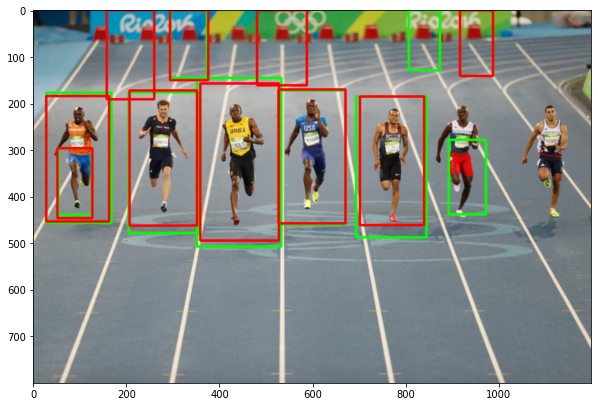

processing: images/pedestrians/4.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


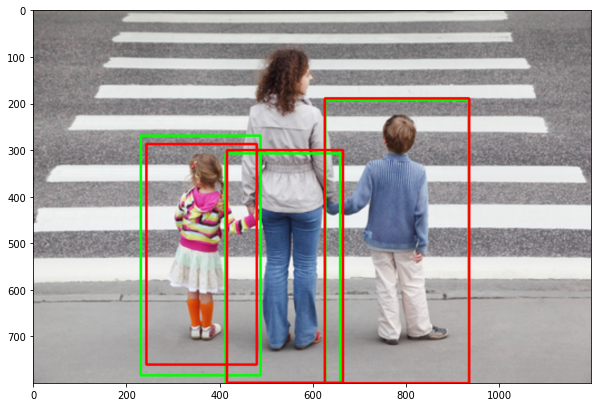

processing: images/pedestrians/5.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 4


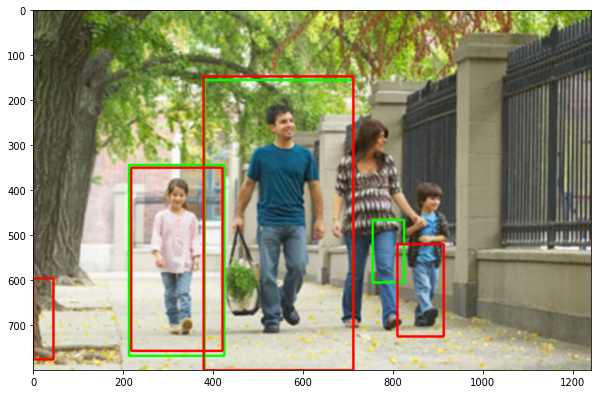

processing: images/pedestrians/2.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


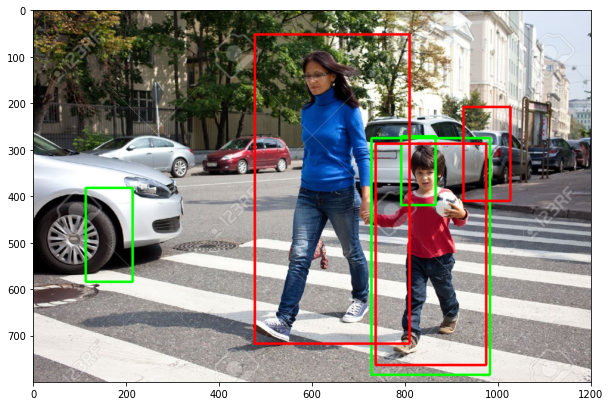

processing: images/pedestrians/3.jpg
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 2


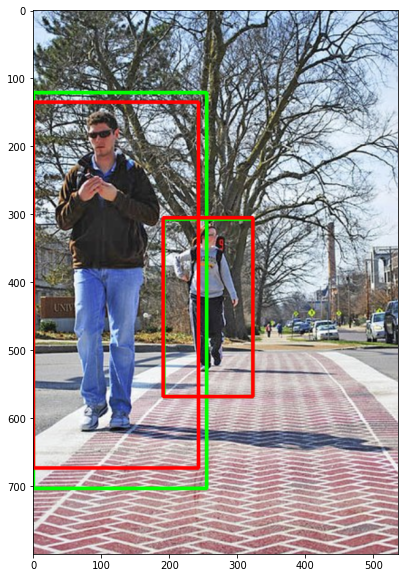

processing: images/pedestrians/1.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 6


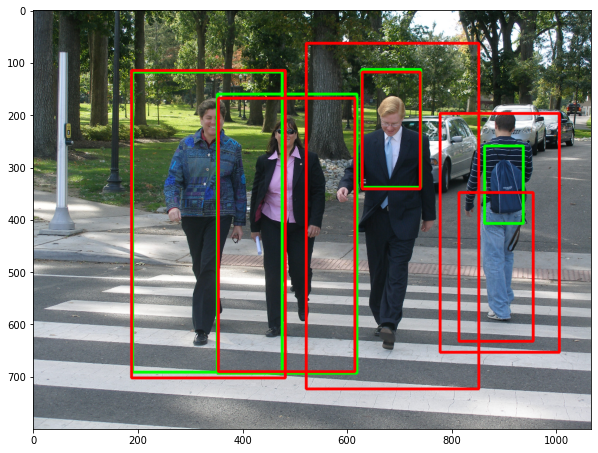

In [ ]:
# read images from pedestrians directory
imageDir = 'images/pedestrians'
imagePaths = glob.glob(os.path.join(imageDir, '*.jpg'))

# We will run pedestrian detector at an fixed height image
finalHeight = 800.0

for imagePath in imagePaths:
    print('processing: {}'.format(imagePath))

    # 1.read image
    

    # 2.resize image to height finalHeight
    scale = finalHeight / im.shape[0]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    
    # 3. Detect people using trained and default SVM detectors
    #    detectMultiScale using detector trained by you

    

    # 4. detectMultiScale using default detector
    
    
    
    # 5. Draw found rectangles on image. We will draw 
    #    green boxes for people detected by trained model and 
    #    red boxes for people detected by OpenCV’s default model.
    #    print pedestrians detected
    if len(bboxes) > 0:
        print('Trained Detector :: pedestrians detected: {}'
                .format(bboxes.shape[0]))
    if len(bboxes2) > 0:
        print('Default Detector :: pedestrians detected: {}'
                .format(bboxes2.shape[0]))

    # 5.1 Draw detected bouunding boxes over image
    # 5.2 Red = default detector, Green = Trained Detector



    
    # Finally show the result and also write it to disk.
    # Show final result
    plt.imshow(im[:,:,::-1])
    # Write image to disk
    imResultPath = os.path.join('results', os.path.basename(imagePath))
    cv2.imwrite(imResultPath, im)
    plt.show()

### (Question) Como se compara su modelo entreado con el modelo predefinido de openCV? Cual es mejor? Por que? Explique

__Answer:__

## Conclusiones (Minimo 150 palabras)

Write Here

---
## Exercise 2: Aplicacion de Filtros en el rostro usando Haar Cascades - 8 pts

En el anterior ejercicio, se hablo sobre la detección de objetos basada en las características de HOG. En este ejercicio, se realizara la detección de rostros y sonrisas para la realizacion de una aplicacion. Note que los mismos conceptos se aplican también a la detección general de objetos.

A Paul Viola y Michael Jones se les ocurrió su [artículo](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=G2-nFaIAAAAJ&citation_for_view=G2-nFaIAAAAJ:u5HHmVD_uO8C) que no solo detectó rostros de manera sólida, sino lo hizo en tiempo real. Es uno de los artículos más citados en Computer Vision. Lea el paper y asegurese de entender los conceptos claves de este.

Debe usar los detectores de cara y sonrisa basados en haar de OpenCV. Luego, utilizara esto para realizar una aplicacion de retoque en el rostro.

# Face Detection in OpenCV

La implementación de detección de rostros utilizando cascadas de Haar en OpenCV. El modelo entrenado para la detección de rostros y de sonrisas está presente en la carpeta de modelos, que se descarga desde [aquí](https://github.com/opencv/opencv/tree/master/data/haarcascades).

El detector de rostros es aportado por [Prof. Dr. Rainer Leinhart](https://scholar.google.com/citations?user=eKQPhGgAAAAJ&hl=en) y el detector de sonrisas de [Deniz Suarez](http://visilab.etsii.uclm.es/personas/oscar/oscar.html). Los modelos se guardan en archivos xml. Hay otros detectores de objetos basados en cascada haar en OpenCV que son entrenados por varios investigadores y compartidos a través de OpenCV, como detector de ojos, detector de cara de perfil, detector de cara de gato, detector de peatones.

In [129]:
# Load the cascade classifier from the xml file.
faceCascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')

# Change this parameters to experiment with the model
faceNeighborsMax = 10
neighborStep = 1

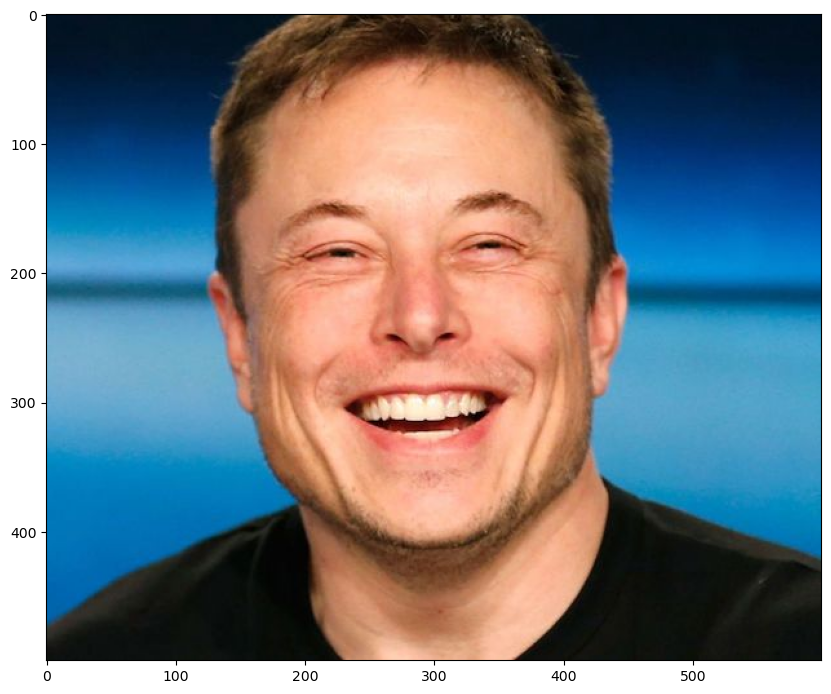

In [130]:
# Read the image
frame = cv2.imread("images/musk.jpg")
frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(frame[:,:,::-1])

## 1. Face detector

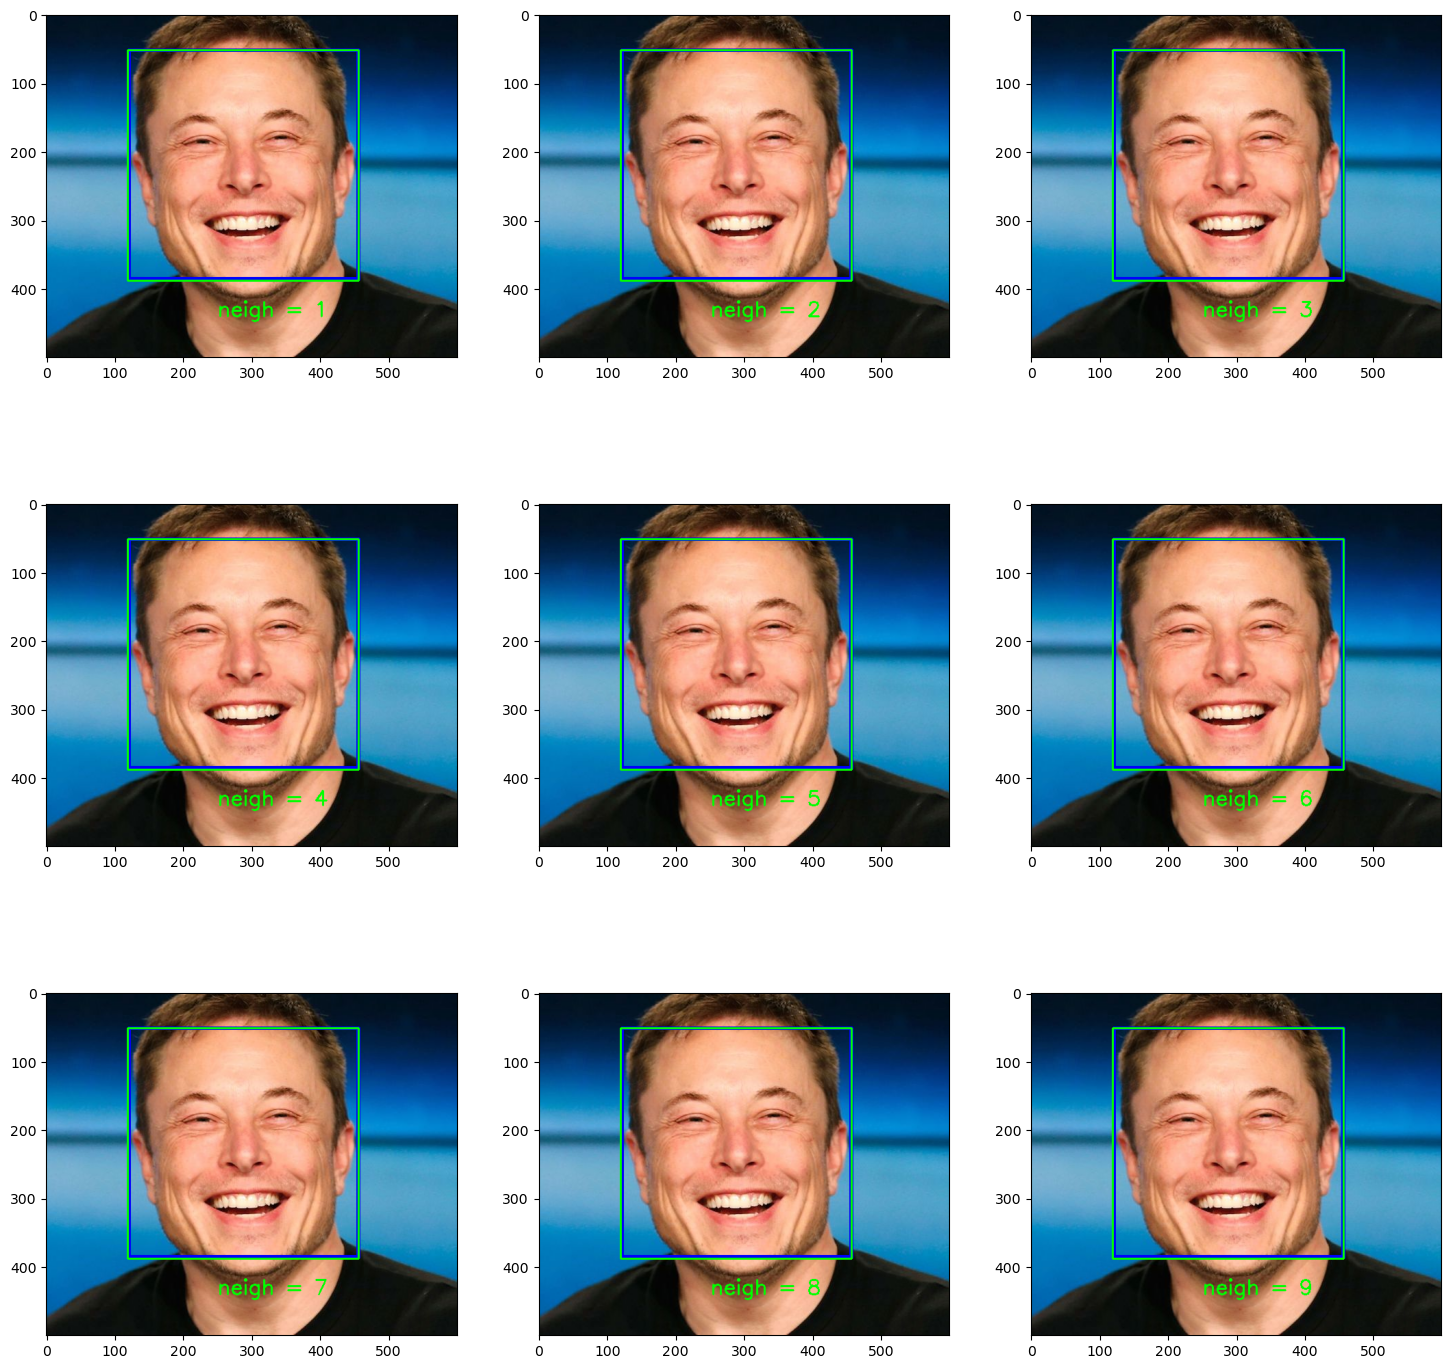

In [209]:
# Perform multi scale detection of faces
plt.figure(figsize=(18,18))
count = 1
for neigh in range(1, faceNeighborsMax, neighborStep):
    # 1. Detec faces
    faces = faceCascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=neigh, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    # 2. make a copy 
    frameClone = frame.copy()
    # 3. draw a rectangle for each found face (for loop)
    for (x, y, w, h) in faces:
        cv2.rectangle(frameClone, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 4. put some text, indicating the neighbors (read the documentation)
    text = f"neigh = {neigh}"

    cv2.putText(frameClone, text, (250, 440), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Draw current img 
    plt.subplot(3,3,count)
    plt.imshow(frameClone[:,:,::-1])
    
    # increment count
    count += 1

plt.show()

## 2. Load detectors

In [258]:
# Detect the face using the cascade
faceCascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')

# 1. Read smile detector
smileCascade = cv2.CascadeClassifier('models/haarcascade_smile.xml')
smileNeighborsMax = 10
neighborStep = 1

frame = cv2.imread("images/musk.jpg")

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# use the best found value for your face detector
faces =  faceCascade.detectMultiScale(frameGray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

## 2.1 Smile detector

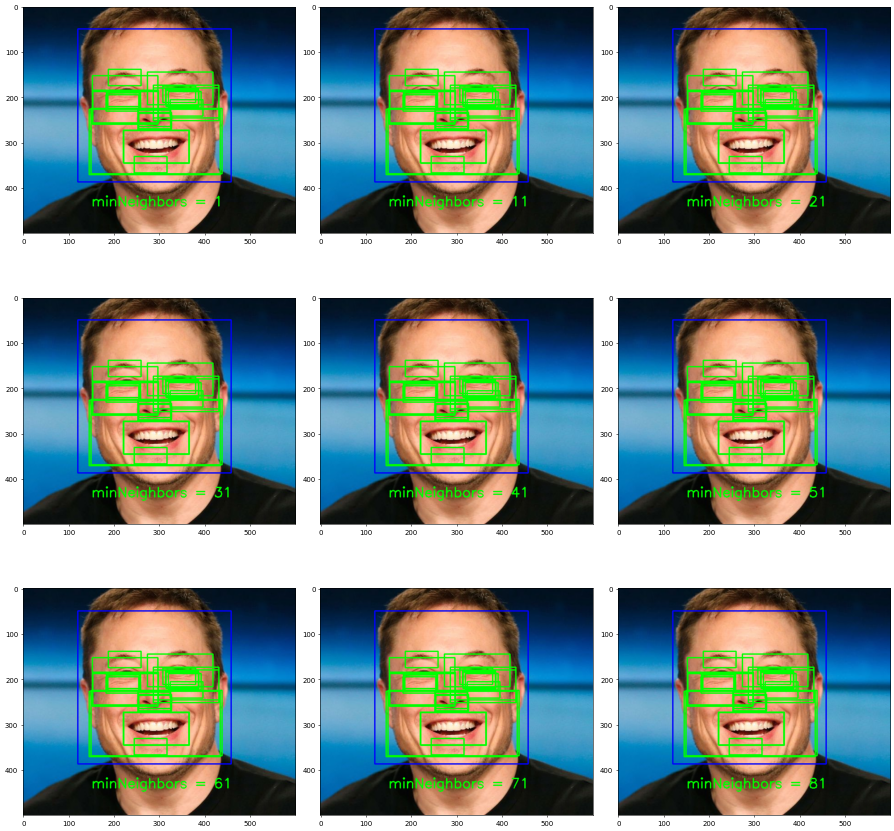

In [260]:
plt.figure(figsize=(18,18), dpi=50)

# TODO
# Detect the smile from the detected face area and display the image
# Use similar code from face detector!

count = 1
minNeighbor = 1
# 1. Get the face area from the detected face rectangle
for (x, y, w, h) in faces:
    face_area = frameGray[y:y+h, x:x+w].copy()
    
    # 2. Draw rectangle in the image
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # 3. Extract only the face from the original image
    color_face = frame[y:y+h, x:x+w]
    for neigh in range(1, smileNeighborsMax, neighborStep):
        # 1. Detec smile
        smile = smileCascade.detectMultiScale(color_face, scaleFactor=2, minNeighbors=1 + 100 * (neigh - 1), 
                                                    minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
        # 2. make a copy 
        frameClone = frame.copy()
        # 3. draw a rectangle for each found smile (for loop)
        for (x_s, y_s, w_s, h_s) in smile:
            cv2.rectangle(color_face, (x_s, y_s), (x_s+w_s, y_s+h_s), (0, 255, 0), 2)

        # 4. put some text, indicating the neighbors (read the documentation)
        text = f"minNeighbors = {minNeighbor}"

        cv2.putText(frameClone, text, (150, 440), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        frameClone[y:y+h, x:x+w] = color_face

        # Draw current img 
        plt.subplot(3,3,count)
        plt.imshow(frameClone[:,:,::-1])
        
        # increment count
        count += 1
        minNeighbor += 10
plt.tight_layout()
plt.show()


## 3. Aplicacion 

1. Si se encuentra una sonrisa en la imagen, entonces para aquella persona aplicar un filtro que lo haga ver mas joven!! Luego, se debe mostrar la imagen de la persona pero con el filtro aplicado. 
2. Si no se encuentra una sonrisa no se debe aplicar ningun filtro y solo se debe mostrar la imagen con el rostro detectado
3. Pruebe su aplicacion con otras imagenes! Al menos dos pruebas adicionales!

__Hint__: Se recomienda que analice la imagen en hsv y aplique una mas cara sobre el rostro encontrado para eliminar las arrugas!

Smiles: 1 Neigh: 6
Smiles: 1 Neigh: 6


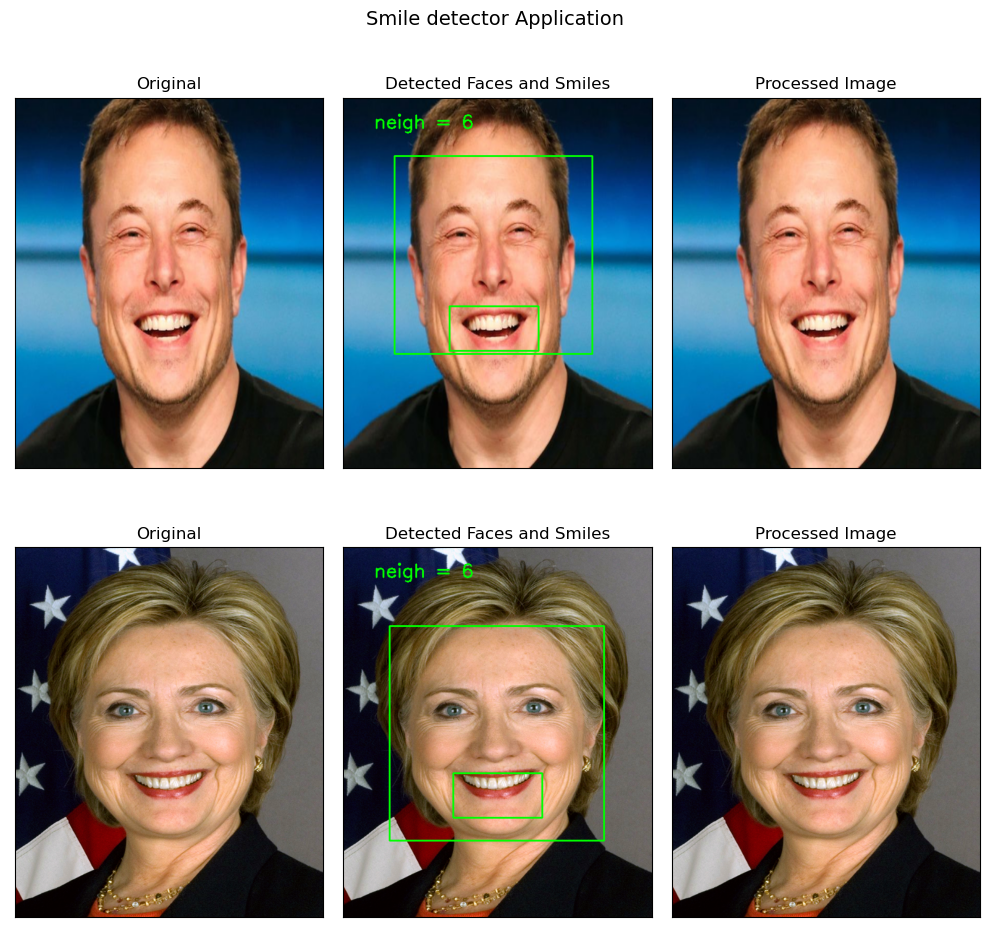

In [241]:
#neigh 4-6
samples=[cv2.imread("images/musk.jpg"), cv2.imread("images/hillary_clinton.jpg")]
samples=[cv2.resize(sample, dsize=(500, 600)) for sample in samples]
smilies=[]
smile_and_young=[]

neigh=6
for sample in samples:
    # Make a copy 
    sample_copy = sample.copy()
    #get image witout marks to filter
    sample_copy_2 = sample.copy()

    #Detect face area
    faces = faceCascade.detectMultiScale(sample_copy, scaleFactor=1.1, 
                                    minNeighbors=neigh, minSize=(30, 30))
    # Iterar sobre cada cara encontrada
    for (x, y, w, h) in faces:
        # take face
        face = sample_copy_2[y:y+h, x:x+w]
        #indicate neighborhood
        text = f"neigh = {neigh}"
        cv2.putText(sample_copy, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        #draw rectangle arounf face
        cv2.rectangle(sample_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Detect smile from the detected face area
        smiles = smileCascade.detectMultiScale(sample_copy, scaleFactor=2, 
                minNeighbors=neigh*10, 
                minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
        print(f'Smiles: {len(smiles)} Neigh: {neigh}')
        # Verificar si se detectó solo una sonrisa
        if len(smiles) == 1:
            for (x_s, y_s, w_s, h_s) in smiles:
                cv2.rectangle(sample_copy, (x_s, y_s), (x_s+w_s, y_s+h_s), (0, 255, 0), 2)

            #append smiley face
            smilies.append(sample_copy)
            ##TODO:filter face
            # give face back
            sample_copy_2[y:y+h, x:x+w] = face
            #append young face
            smile_and_young.append(sample_copy_2)
        else:
            smilies.append(np.zeros_like(sample))
            smile_and_young.append(np.zeros_like(sample))


n_rows=2
n_cols=3
# create a new figure
fig, axs = plt.subplots(n_rows, n_cols, dpi=100)
# loop over the rows and columns and plot the images
for i in range(n_rows):
    for j in range(n_cols):
        if j == 0:
            axs[i,j].imshow(samples[i][:,:,::-1])
            axs[i,j].set_title('Original')
        elif j == 1:
            axs[i,j].imshow(smilies[i][:,:,::-1])
            axs[i,j].set_title('Detected Faces and Smiles')
        elif j == 2:
            axs[i,j].imshow(smile_and_young[i][:,:,::-1])
            axs[i,j].set_title('Processed Image')

# set the axis labels and title
fig.suptitle('Smile detector Application', fontsize=14)
plt.setp(axs, xticks=[], yticks=[])
plt.tight_layout()
plt.subplots_adjust(top=0.95)
#fig.savefig("results/Ex2-Process-to-Isolate-Semaphore.png",bbox_inches='tight')
plt.show()

## Opcional. Utilice otros haar like features por ejemplo para detectar ojos. 

### (Question) Que hace el parametro neighbors en el clasificador? Como afecta este parametro en la deteccion de objetos?

__answer__:

## Conclusiones (minimo 150 palabras)

Write Here

## Refencias
1. [https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

3. [https://en.wikipedia.org/wiki/Support_vector_machine](https://en.wikipedia.org/wiki/Support_vector_machine)

4. [http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/](http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/)

5. http://blog.dlib.net/2014/02/dlib-186-released-make-your-own-object.html

6. https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework

7. http://www.merl.com/publications/docs/TR2004-043.pdf

8. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

9. http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html

10. http://docs.opencv.org/3.2.0/db/d28/tutorial_cascade_classifier.html

11. http://docs.opencv.org/trunk/dc/d88/tutorial_traincascade.html